## //TODO: Get Y Labels
#### You should probably do this in API.py, so that there can be a different method you call from this cell which chooses tickers, calls getSamples to retrieve the requested X data, selects the samples we want from the X data, and then calculates Y using the <date> in X

In [310]:
import os
import requests
import numpy as np
import pandas as pd
import imp

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler

import statsmodels.tsa.api as tsa
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

from api_keys import fmp_api_key as api_key
# from API import API
import API
imp.reload(API)
from API import API


api = API(api_key, period='quarter', limit=None)
tickers = api.getRandTickers(50)
# tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']

X = api.getSamplesFromTickers(tickers, samplesPerTicker=100, maxTickers=50)
Y = api.getYFromDF(X)


Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
M

In [311]:
print(api.getNumApiCalls())

113


## Format X and Y Data

In [312]:
print(tickers)

baselinePercentage = .06
Y['baselinePercentage'] = Y.apply(lambda row: baselinePercentage, axis=1)

merged = pd.merge(X, Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()

['IZEA', 'RAYT', 'PRU.L', 'BGLUX', 'IEX', '5GN.AX', 'TOU.AX', 'MTXX.L', 'HIL.NS', 'SEZAL.NS', 'RCL', 'TRU', 'IHF', 'ADES', '1468.HK', 'EGOIX', 'AZEK', 'ESGRP', '0VOU.L', 'CMC.DE', 'GSF.OL', '8668.HK', 'SPSM', '6111.HK', 'GSXIX', 'KUANTUM.NS', 'NAGREEKEXP.NS', 'BNR', 'SUSB', 'YGMZ', 'CROMPTON.NS', 'WMT', 'APLS', 'TRF.NS', 'EME.L', 'EUDG', '1675.HK', 'GFL.TO', 'ASY.PA', 'DMRM', 'GUSH', 'RLITX', 'XSE.TO', 'DCU.TO', '0604.HK', 'ATXG', 'FTHCX', 'BCYPW', '8356.HK', 'SCYYF']


In [313]:
X = merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage', 'baselinePercentage'], axis=1)
Y = merged[['percentage']]
Y_baseline = merged[['baselinePercentage']]

In [314]:
# display(merge)
display(X.head())
print(X.columns)
print(X.shape)
display(Y.head())
print(Y.shape)
display(Y_baseline.head())
print(Y_baseline.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,2.431010,1.513747,0.409010,0.168578,0.018267,0.031756,0.032326,0.738437,1.804952,6.066010,...,0.075210,0.049342,-0.014218,0.036785,0.069364,0.067788,0.103017,0.093242,2.296142e+09,2.607395e+09
1,1.940647,0.954444,0.387531,0.141245,0.016867,0.027369,0.033088,0.622590,2.316768,6.929461,...,0.000900,0.007062,0.003771,0.032180,-0.052230,-0.033929,-0.018414,-0.036641,1.371763e+09,1.539757e+09
2,2.042425,1.001052,0.374639,0.119711,0.013072,0.024016,0.027289,0.837148,2.083533,5.630259,...,-0.001779,-0.018893,-0.010722,0.070317,-0.150614,-0.166784,-0.176856,-0.180615,1.055916e+09,1.290015e+09
3,3.386753,2.376851,0.449305,0.209257,0.025255,0.045989,0.043155,0.820991,3.620987,10.789809,...,0.020316,0.076697,0.030431,0.060494,0.077563,0.095906,0.103516,0.108434,5.869613e+09,6.191475e+09
4,3.034460,1.942392,0.449842,0.213465,0.023967,0.047831,0.042343,0.995698,4.184249,11.822690,...,0.025743,0.024659,-0.000581,-0.020743,0.072580,0.080112,0.055054,0.062272,6.087278e+09,6.651029e+09


Index(['currentRatio', 'quickRatio', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnEquity',
       'returnOnCapitalEmployed', 'debtEquityRatio', 'priceToBookRatio',
       'priceToSalesRatio', 'priceEarningsRatio', 'priceEarningsToGrowthRatio',
       'priceToOperatingCashFlowsRatio', 'growthRevenue',
       'growthCostOfRevenue', 'growthGrossProfit', 'growthGrossProfitRatio',
       'growthOperatingExpenses', 'growthEBITDA', 'growthOperatingIncome',
       'growthNetIncome', 'growthEPS', 'marketCapitalization',
       'enterpriseValue'],
      dtype='object')
(106, 24)


,percentage
0,0.604830
1,0.460688
2,0.271865
3,0.040335
4,0.044795


(106, 1)


,baselinePercentage
0,0.06
1,0.06
2,0.06
3,0.06
4,0.06


(106, 1)


## Plot Features to Examine Distributions

<ipython-input-315-82ac20f67b5e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


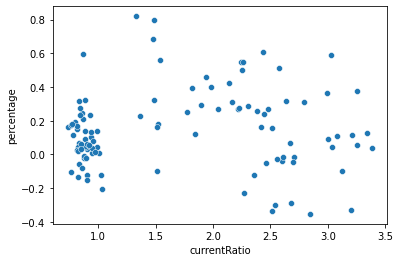

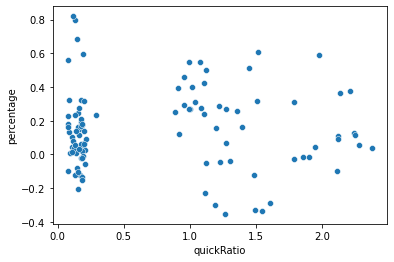

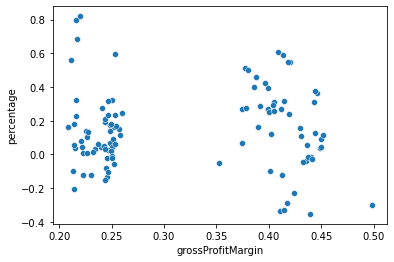

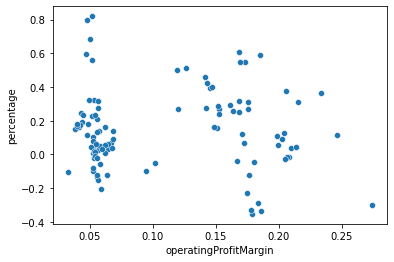

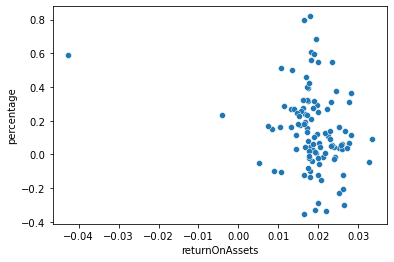

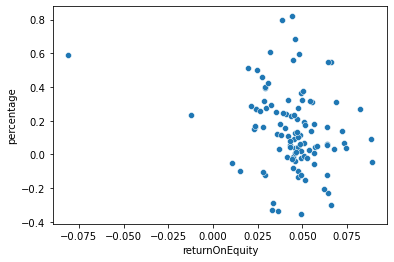

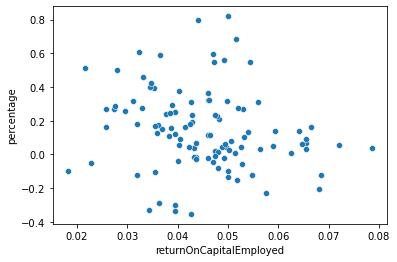

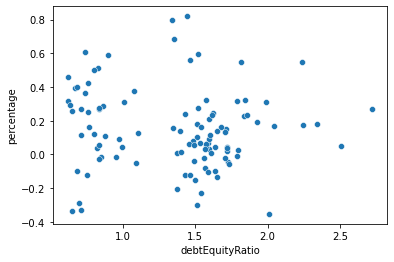

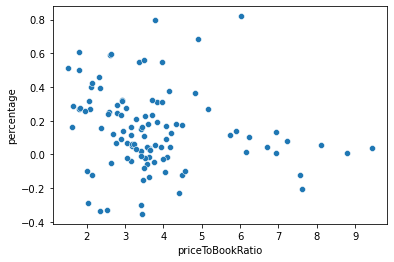

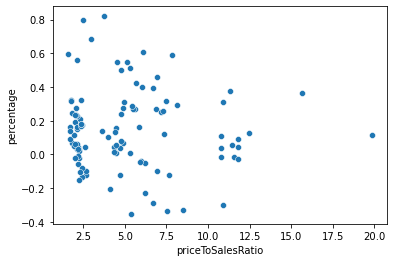

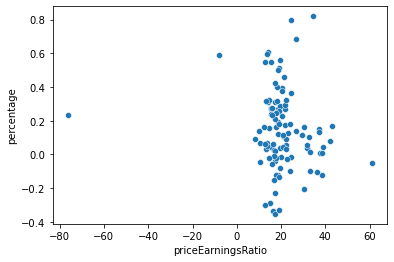

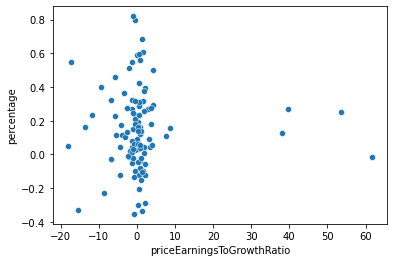

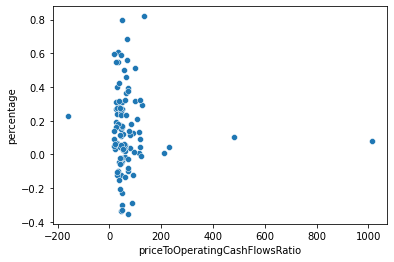

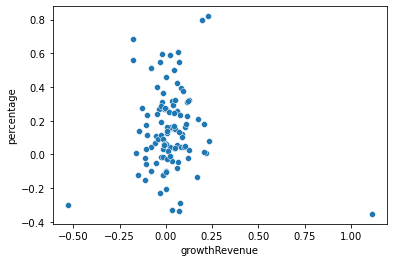

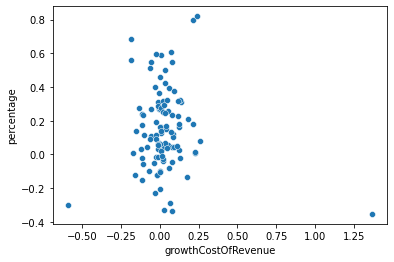

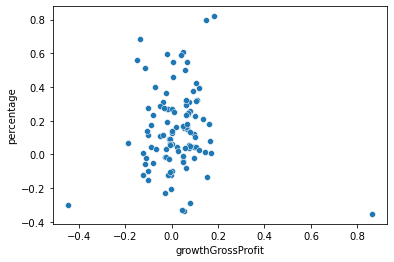

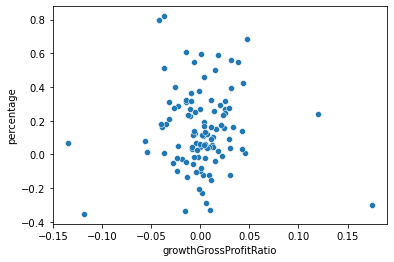

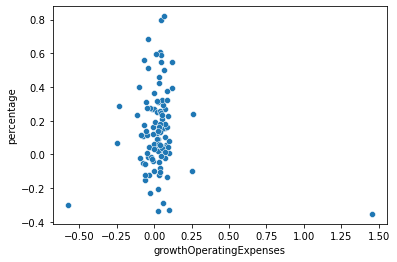

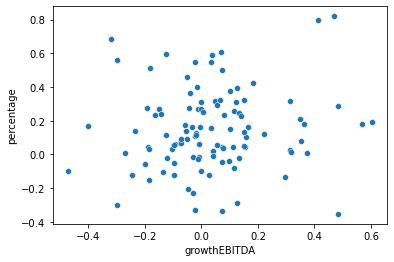

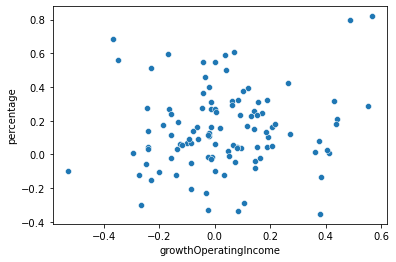

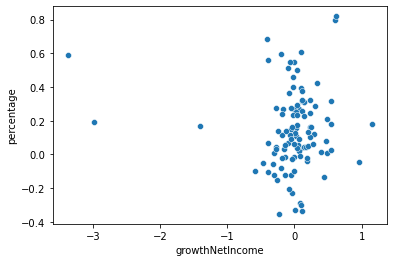

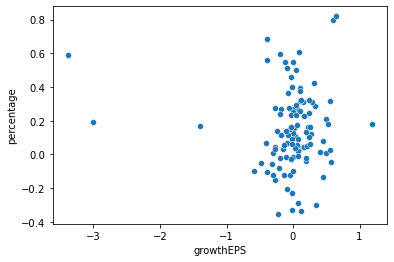

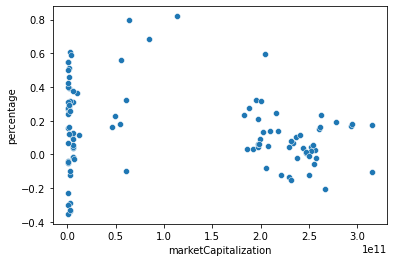

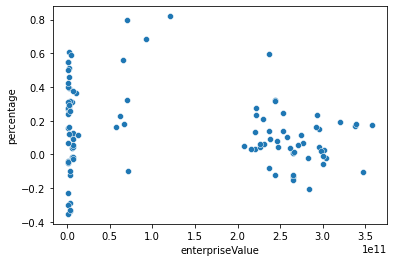

In [315]:
# plt.figure()
for colName in X:
  plt.figure()
  sns.scatterplot(data=merged, x=colName, y='percentage')

## Scaling/ Normalization

In [316]:
# min_max_scaler = MinMaxScaler((-1, 1))
# df[percentages] = min_max_scaler.fit_transform(df[percentages])  # No need, because percentages are already on a good scale
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X), columns = X.columns)
display(X_scaled.head())



,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,0.848868,1.044246,0.971199,0.914629,-0.032412,-0.616550,-1.134368,-1.345176,-1.225556,0.278933,...,0.288254,0.222848,-0.437010,0.061985,0.182079,0.167707,0.241474,0.219160,-0.971956,-0.973245
1,0.277402,0.269392,0.737072,0.491548,-0.204497,-0.835141,-1.067234,-1.592757,-0.899468,0.527231,...,-0.148028,-0.121426,0.080812,0.034343,-0.438301,-0.325250,0.014878,-0.023538,-0.980064,-0.981496
2,0.396013,0.333963,0.596554,0.158227,-0.671027,-1.002183,-1.578253,-1.134218,-1.048066,0.153626,...,-0.163755,-0.332773,-0.336355,0.263261,-0.940257,-0.969118,-0.280782,-0.292566,-0.982835,-0.983426
3,1.962684,2.239981,1.410414,1.544306,0.826656,0.092557,-0.180094,-1.168748,-0.068525,1.637331,...,-0.034034,0.445594,0.848210,0.204299,0.223912,0.303977,0.242405,0.247546,-0.940610,-0.945547
4,1.552124,1.638086,1.416267,1.609438,0.668334,0.184334,-0.251631,-0.795373,0.290339,1.934351,...,-0.002174,0.021861,-0.044462,-0.283320,0.198488,0.227437,0.151972,0.161289,-0.938701,-0.941995


## Reduce Dimensionality with PCA

In [317]:
pca = PCA(n_components='mle')
X_pc = pca.fit_transform(X_scaled)
# print(pca.components_)
# print(pca.explained_variance_)
display(X_pc.shape)

(106, 23)

## Examine Distribution on 1st Principle Component

In [318]:
# plt.scatter(X_pc[:,0], Y)
print(X_pc[:,0].shape)
print(Y.shape)
print(Y)

(106,)
(106, 1)
     percentage
0      0.604830
1      0.460688
2      0.271865
3      0.040335
4      0.044795
..          ...
101   -0.021745
102   -0.101032
103    0.055986
104    0.139993
105    0.032584

[106 rows x 1 columns]


## Transform Data to Polynomial Features, Train Models, and Plot Error

In [319]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def trainAndGetResults(X, baseline=False):
    results = {'clf': [] , 'x': [], 'X_train': [], 'Y_pred': [], 'Y_test': [], 'mse': [], 'rmse': []}
    for i in range(1, 5):
        if not baseline:
            print("X Shape = ")
            print(X.shape)
            poly = PolynomialFeatures(degree=i)
            poly_features = poly.fit_transform(X)
            X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size=0.33, random_state=42)

            clf = LinearRegression()
            print("Poly Shape = ")
            print(poly_features.shape)
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test)
            results['clf'].append(clf)
            results['X_train'].append(X_train)
            results['Y_pred'].append(Y_pred)
            results['Y_test'].append(Y_test)

            mse = mean_squared_error(Y_test, Y_pred)
            rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        else:
            mse = mean_squared_error(Y, Y_baseline)
            rmse = mean_squared_error(Y, Y_baseline, squared=False)

        results['x'].append(i)
        results['mse'].append(mse)
        results['rmse'].append(rmse)
    return results

trueBaseResults = trainAndGetResults(X)
baselineBaseResults = trainAndGetResults(X, baseline=True)
truePcResults = trainAndGetResults(X_pc)
baselinePcResults = trainAndGetResults(X_pc, baseline=True)

X Shape = 
(106, 24)
Poly Shape = 
(106, 25)
X Shape = 
(106, 24)
Poly Shape = 
(106, 325)
X Shape = 
(106, 24)
Poly Shape = 
(106, 2925)
X Shape = 
(106, 24)
Poly Shape = 
(106, 20475)
X Shape = 
(106, 23)
Poly Shape = 
(106, 24)
X Shape = 
(106, 23)
Poly Shape = 
(106, 300)
X Shape = 
(106, 23)
Poly Shape = 
(106, 2600)
X Shape = 
(106, 23)
Poly Shape = 
(106, 17550)


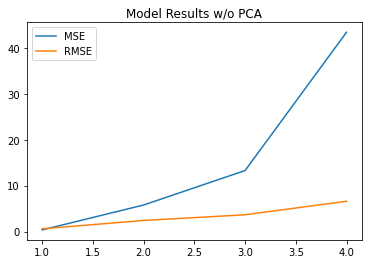

MSEs: [0.34543996987931014, 5.775611425015367, 13.281354486253411, 43.41467901833571]
RMSEs: [0.5877414141264082, 2.4032501794476926, 3.6443592696458196, 6.588981637425901]

1's top 3 weights were [52.81205329 10.60833105  4.26877327]
at [ 5 14 17]
2's top 3 weights were [9.12078823e-10 6.73694272e-10 3.04303995e-10]
at [269 268 295]
3's top 3 weights were [1.71174047e-21 1.43367695e-21 1.17922551e-21]
at [1955 1954 1953]
4's top 3 weights were [6.22675053e-33 4.92133739e-33 4.84657389e-33]
at [ 2924 20345 20439]


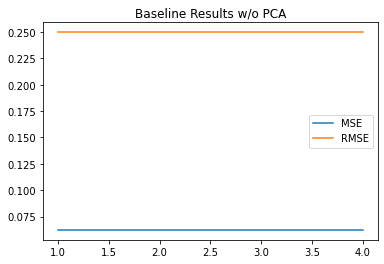

MSEs: [0.062342515696056845, 0.062342515696056845, 0.062342515696056845, 0.062342515696056845]
RMSEs: [0.24968483273129918, 0.24968483273129918, 0.24968483273129918, 0.24968483273129918]



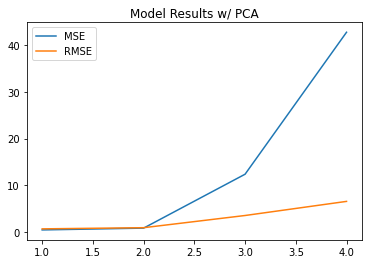

MSEs: [0.424928793835423, 0.8111225792569737, 12.37282125902151, 42.82027128644486]
RMSEs: [0.6518656255973488, 0.9006234392114019, 3.5175021334778904, 6.543719988389238]

1's top 3 weights were [1.50990372 1.22578602 0.35560823]
at [22 23 19]
2's top 3 weights were [0.26281382 0.23010093 0.20895341]
at [209 120 167]
3's top 3 weights were [0.02872957 0.02639498 0.0252111 ]
at [ 306   27 2236]
4's top 3 weights were [0.00994423 0.00808299 0.00772867]
at [2673 2886 4907]


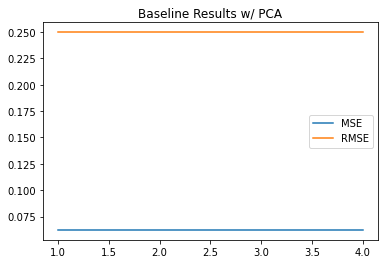

MSEs: [0.062342515696056845, 0.062342515696056845, 0.062342515696056845, 0.062342515696056845]
RMSEs: [0.24968483273129918, 0.24968483273129918, 0.24968483273129918, 0.24968483273129918]



In [320]:
def plotResults(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()
    for x, clf in zip(results['x'], results['clf']):
        coef = clf.coef_.ravel()
        max_3_idx = coef.argsort()[-3:][::-1]
        print("{}'s top 3 weights were {}".format(x, coef[max_3_idx]))
        print("at {}".format(max_3_idx))

plotResults(trueBaseResults, "Model Results w/o PCA")
plotResults(baselineBaseResults, "Baseline Results w/o PCA")
plotResults(truePcResults, "Model Results w/ PCA")
plotResults(baselinePcResults,"Baseline Results w/ PCA")


## Train Neural Net Model

In [321]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

def trainAndGetResultsNN(X, baseline=False):
    results = {'clf': [] , 'x': [], 'X_train': [], 'Y_pred': [], 'Y_test': [], 'mse': [], 'rmse': []}
    for i in range(1, 2):
        if not baseline:
            print("X Shape = ")
            print(X.shape)
            
            # poly_features = X
            poly = PolynomialFeatures(degree=1)
            poly_features = poly.fit_transform(X)
            
            X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size=0.33, random_state=42)

            learning_rate_init = 0.001 / (1 * 30.0) # 30 yields best results
            epsilon = 1 * 10 ** -(2) # 1e-2 yields best results
            # epsilon = 1e-8
            clf = MLPRegressor(random_state=1, max_iter=50000, learning_rate_init=learning_rate_init, epsilon=epsilon)
            clf.fit(X_train, Y_train.values.ravel()) # Y_train.values.ravel()
            Y_pred = clf.predict(X_test)
            
    
            results['clf'].append(clf)
            results['X_train'].append(X_train)
            results['Y_pred'].append(Y_pred)
            results['Y_test'].append(Y_test)

            mse = mean_squared_error(Y_test, Y_pred)
            rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        else:
            mse = mean_squared_error(Y, Y_baseline)
            rmse = mean_squared_error(Y, Y_baseline, squared=False)

        results['x'].append(i)
        results['mse'].append(mse)
        results['rmse'].append(rmse)
    return results

trueBaseResultsNN = trainAndGetResultsNN(X)
baselineBaseResultsNN = trainAndGetResultsNN(X, baseline=True)
truePcResultsNN = trainAndGetResultsNN(X_pc)
baselinePcResultsNN = trainAndGetResultsNN(X_pc, baseline=True)

X Shape = 
(106, 24)
X Shape = 
(106, 23)


## Plot Neural Net Model

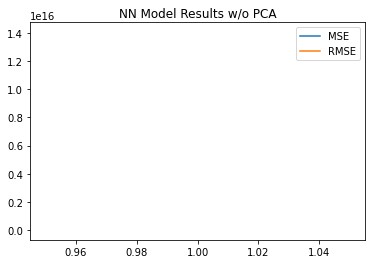

MSEs: [1.4061187936999858e+16]
RMSEs: [118579879.98391573]



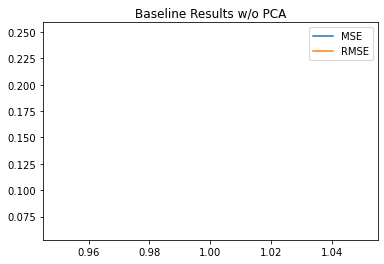

MSEs: [0.062342515696056845]
RMSEs: [0.24968483273129918]



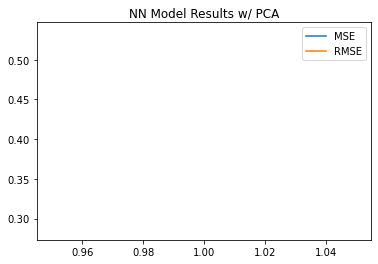

MSEs: [0.2858033443370838]
RMSEs: [0.5346057840475389]



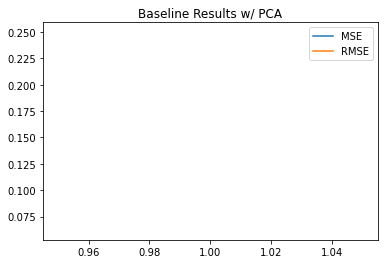

MSEs: [0.062342515696056845]
RMSEs: [0.24968483273129918]



In [322]:
def plotResultsNN(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()
    """for x, clf in zip(results['x'], results['clf']):
        coef = clf.coef_.ravel()
        max_3_idx = coef.argsort()[-3:][::-1]
        print("{}'s top 3 weights were {}".format(x, coef[max_3_idx]))
        print("at {}".format(max_3_idx))"""

plotResultsNN(trueBaseResultsNN, "NN Model Results w/o PCA")
plotResultsNN(baselineBaseResultsNN, "Baseline Results w/o PCA")
plotResultsNN(truePcResultsNN, "NN Model Results w/ PCA")
plotResultsNN(baselinePcResultsNN,"Baseline Results w/ PCA")

## Real-World Results

In [323]:
# Collect data from 10 different stocks
final_tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']
final_pca = PCA(n_components=21)
final_poly = PolynomialFeatures(degree=1)

spy_X = api.getSamplesFromTickers(final_tickers, samplesPerTicker=50, maxTickers=10)
spy_Y = api.getYFromDF(spy_X)

Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Date 2007-03-31 not found for AAPL
Date 2015-03-28 not found for AAPL
Date 1999-06-26 not found for AAPL
Date 1998-03-27 not found for AAPL
Date 2007-06-30 not found for AAPL
Date 2009-03-28 not found for AAPL
Date 2015-09-26 not found for AAPL
Date 1997-12-26 not found for AAPL
Date 2017-07-01 not found for AAPL
Date 2014-

In [324]:
print(api.getNumApiCalls())

143


In [325]:
spy_merged = pd.merge(spy_X, spy_Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()
spy_X = spy_merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage'], axis=1)
spy_Y = spy_merged[['percentage']]

spy_X_scaled = pd.DataFrame(ss.fit_transform(spy_X), columns = spy_X.columns)
spy_X_pc = final_pca.fit_transform(spy_X_scaled)
spy_X_poly = final_poly.fit_transform(spy_X_scaled)
spy_X_pc_poly = final_poly.fit_transform(spy_X_pc)

In [326]:
display(spy_X.head())

print(spy_X.shape)
print(spy_Y.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,2.408181,1.159514,0.425086,0.120382,0.035888,0.070659,0.081439,0.968898,3.150645,3.595607,...,0.001648,0.028171,0.013873,0.053745,-0.008826,-0.044202,-0.025167,-0.018124,7.192293e+09,6.798493e+09
1,2.372470,1.485405,0.541808,0.136318,0.047667,0.097405,0.109544,1.043428,3.272193,3.017526,...,0.000000,0.000000,0.000000,0.000000,-0.809486,-0.847781,0.000000,0.297260,5.055865e+09,4.339565e+09
2,2.417060,1.183192,0.463331,0.140986,0.044320,0.086332,0.106114,0.947941,3.578668,3.694332,...,0.006513,-0.091210,-0.046956,-0.060347,-0.156080,-0.183012,-0.128904,-0.156269,6.881063e+09,6.396663e+09
3,2.486968,1.256414,0.406252,0.085668,0.024809,0.048508,0.056355,0.955253,2.715416,3.145034,...,0.261380,0.026313,-0.107139,-0.028530,0.084785,0.197414,0.224753,0.240693,6.207983e+09,5.707283e+09
4,2.854468,2.679428,0.685191,0.383785,0.038279,0.100678,0.057445,1.630137,10.007024,32.108759,...,-0.000576,-0.028148,-0.008685,-0.085963,0.021397,0.022652,-0.190263,-0.186047,1.061355e+12,1.117733e+12


(111, 24)
(111, 1)


In [327]:
# print(truePcResults['clf'][0])
print(spy_X_poly.shape)
print(spy_X_pc_poly.shape)

(111, 25)
(111, 22)


In [329]:
r1 = trueBaseResults['clf'][0].predict(spy_X_poly)
r2 = truePcResults['clf'][0].predict(spy_X_pc_poly)

r1MSE = mean_squared_error(spy_Y, r1)
r2MSE = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE)
print(r2MSE)
print(baseMSE)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 24 is different from 22)

In [331]:
r1 = trueBaseResultsNN['clf'][0].predict(spy_X_poly)
# r2 = truePcResultsNN['clf'][0].predict(spy_X_pc_poly)
r2 = truePcResultsNN['clf'][-1].predict(spy_X_pc_poly)

r1MSE_NN = mean_squared_error(spy_Y, r1)
r2MSE_NN = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE_NN)
print(r2MSE_NN)
print(baseMSE)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 24 is different from 22)